In [23]:
from pathlib import Path
data_path = ".\\DCC\\TST\\tst1s.mat"
pipe_path = ".\\DCC\\lpn-data-analysis\\"
import sys
import os
sys.path.append(data_path)
sys.path.append(pipe_path)
import data_tools
import validation_tools
import re
import itertools

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
device="cpu"
def mouse_Data_Extractor(data_shape,mice_labels,mice_to_remove):
    Row_Idxs = np.zeros(data_shape[0])    
    for i in range(len(Row_Idxs)):
        if mice_labels[i] in mice_to_remove:
            Row_Idxs[i] = True
        else:
            Row_Idxs[i] = False            
    return Row_Idxs == True
    
def brainRegionRemover(labels,regions_To_Remove,features):
    Idx = 0
        #power features
    if "power" in features:
        for i in range(len(regions_To_Remove)):
            for j in range(len(labels["powerFeatures"])):
                if regions_To_Remove[i] in labels["powerFeatures"][j]:
                    Idx.append(j)                
    return Idx

def batcher(X,batch_size=20):
    idx = np.random.choice(X.shape[0],size=batch_size,replace=False)
    return X[idx]

Running on the GPU


In [24]:
MAX_FREQ = 55
MIN_FREQ = 1
N_FOLDS = 5
MAX_N_TRAIN_MICE = 2
N_TARGET_TEST = 4
N_TARGET_TRAIN = 2
N_SOURCE_TRAIN = 14
TEST_SIZE = 0.2
N_UNIQUE_FEATURES = 605
N_FEATURES_TST = 605

### Import the Data

In [25]:
tst_psd, tst_labels = data_tools.load_data(data_path,feature_list=['power'],f_bounds=(MIN_FREQ,MAX_FREQ))

areas = tst_labels['area']
unique_mice_names = np.unique(tst_labels['windows']['mouse'])
unique_mice_task = np.unique(tst_labels['windows']['task'])
mouse_name_labels = tst_labels['windows']['mouse']
mouse_geno_labels = tst_labels['windows']['genotype']
mouse_task_labels = tst_labels['windows']['task']
tst_mice_names_unique = np.unique(tst_labels['windows']['mouse'])
tst_mice_names = tst_labels['windows']['mouse']

Gene_0_mice = np.unique(np.array(tst_labels['windows']['mouse'])[np.array(tst_labels['windows']['genotype'],dtype=np.bool)==False])
Gene_1_mice = np.unique(np.array(tst_labels['windows']['mouse'])[np.array(tst_labels['windows']['genotype'],dtype=np.bool)==True])

shuffled_unique_names = np.random.choice(unique_mice_names,MAX_N_TRAIN_MICE+N_TARGET_TEST+N_SOURCE_TRAIN,replace=False)
shuffled_Gene_0_names = np.random.choice(Gene_0_mice,(MAX_N_TRAIN_MICE+N_TARGET_TEST+N_SOURCE_TRAIN)//2,replace=False)
shuffled_Gene_1_names = np.random.choice(Gene_1_mice,(MAX_N_TRAIN_MICE+N_TARGET_TEST+N_SOURCE_TRAIN)//2,replace=False)
Target_Test_Mice_Names = shuffled_Gene_0_names[:N_TARGET_TEST//2]
Target_Test_Mice_Names = np.append(Target_Test_Mice_Names,shuffled_Gene_1_names[:N_TARGET_TEST//2])
Target_Train_Mice_Names = shuffled_Gene_0_names[N_TARGET_TEST//2:(N_TARGET_TEST+N_TARGET_TRAIN)//2]
Target_Train_Mice_Names = np.append(Target_Train_Mice_Names,shuffled_Gene_1_names[N_TARGET_TEST//2:(N_TARGET_TEST+N_TARGET_TRAIN)//2])
Source_Train_Mice_Names = shuffled_Gene_0_names[(N_TARGET_TEST+N_TARGET_TRAIN)//2:(N_TARGET_TEST+N_TARGET_TRAIN+N_SOURCE_TRAIN)//2]
Source_Train_Mice_Names = np.append(Source_Train_Mice_Names,shuffled_Gene_1_names[(N_TARGET_TEST+N_TARGET_TRAIN)//2:(N_TARGET_TEST+N_TARGET_TRAIN+N_SOURCE_TRAIN)//2])

source_mouse_specific_idxs = []
target_mouse_specific_idxs = []
target_test_mouse_specific_idxs = []

target_train_psd_idxs = mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],Target_Train_Mice_Names)
target_test_psd_idxs = mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'], Target_Train_Mice_Names)
source_train_psd_idxs = mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],Source_Train_Mice_Names)
for mouse in Source_Train_Mice_Names:
    source_mouse_specific_idxs.append(mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],mouse))
for mouse in Target_Train_Mice_Names:
    target_mouse_specific_idxs.append(mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],mouse))    
for mouse in Target_Test_Mice_Names:
    target_test_mouse_specific_idxs.append(mouse_Data_Extractor(tst_psd.shape,tst_labels['windows']['mouse'],mouse))

train_idxs_source = []
test_idxs_source = []

train_idxs_target_train = []
test_idxs_target_train = []

train_idxs_target_test = []
test_idxs_target_test = []

for mouse in source_mouse_specific_idxs:
    train_idxs, test_idxs = train_test_split(np.where(mouse==True)[0],test_size=0.33,random_state=42)
    train_idxs_source.append(train_idxs)
    test_idxs_source.append(test_idxs)

full_train_idxs_source = [idx for sublist in train_idxs_source for idx in sublist]

for mouse in target_mouse_specific_idxs:
    train_idxs, test_idxs = train_test_split(np.where(mouse==True)[0],test_size=0.33,random_state=42)
    train_idxs_target_train.append(train_idxs)
    test_idxs_target_train.append(test_idxs)

full_train_idxs_target_train = [idx for sublist in train_idxs_target_train for idx in sublist]
    
for mouse in target_test_mouse_specific_idxs:
    train_idxs, test_idxs = train_test_split(np.where(mouse==True)[0],test_size=0.33,random_state=42)
    train_idxs_target_test.append(train_idxs)
    test_idxs_target_test.append(test_idxs)
    
full_train_idxs_target_test = [idx for sublist in train_idxs_target_test for idx in sublist]

### Sklearn NMF model used for initialization

In [26]:
from sklearn.decomposition import NMF

In [27]:
X_train_init = tst_psd[full_train_idxs_source + full_train_idxs_target_train,:]
init_Model = NMF(n_components=25)
init_Model.fit(X_train_init)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=25, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [28]:
W_init = init_Model.components_

In [29]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx,x):
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx,grad_output):
        return grad_output.neg()
    
def grad_reverse(x):
    return GradReverse.apply(x)

class Cycle_VAE_NMF(nn.Module):
    def __init__(self,mouse_names,experiments,input_shapes,n_components,W_init):
        super(Cycle_VAE_NMF,self).__init__()
        
        self.mouse_names = mouse_names
        self.experiments = experiments
        self.input_shapes = input_shapes
        self.Domain_Style_Encoders = []
        self.Domain_Style_Decoders = []
        self.Domain_Style_Adversaries = []
        
        self.dse_hidden_1 = 605
        self.dse_hidden_2 = 605
        self.dsd_hidden_1 = 605 #Number of Unique Channels
        self.dsd_hidden_2 = 605
        self.dsa_hidden_1 = 100
        self.dsa_hidden_2 = 25
        self.n_unique_features = 605
        
        self.se_hidden_1 = 64
        self.se_hidden_2 = 32
        self.n_components = n_components
        
        self.lda_hidden_1 = len(mouse_names)*2
        self.lda_hidden_2 = len(mouse_names)*2
        self.lda_output = len(mouse_names)
        #-------------------------------
        #Define Domain Style Encoders, Decoders and Adversaries
        #-------------------------------
        for mouse, input_shape in zip(mouse_names,input_shapes):
            self.Domain_Style_Encoders.append(
                nn.Sequential(
                    nn.Linear(input_shape,self.dse_hidden_1),
                    nn.Linear(self.dse_hidden_1,self.dse_hidden_2)
                ).to(device)
            )
            
            self.Domain_Style_Decoders.append(
                nn.Sequential(
                    nn.Linear(self.dsd_hidden_1,self.dsd_hidden_2),
                    nn.Linear(self.dsd_hidden_2,input_shape)
                ).to(device)
            )
            
            self.Domain_Style_Adversaries.append(
                nn.Sequential(
                    nn.Linear(input_shape,self.dsa_hidden_1),
                    nn.ReLU(),
                    nn.Linear(self.dsa_hidden_1,self.dsa_hidden_2),
                    nn.ReLU(),
                    nn.Linear(self.dsa_hidden_2,1),
                    nn.Sigmoid()
                )
            )
            
        #-------------------------------
        #Define Shared Encoder Layers
        #-------------------------------
        self.se_lin1 = nn.Linear(self.dse_hidden_2,self.se_hidden_1)
        self.se_lin2 = nn.Linear(self.se_hidden_1,self.se_hidden_2)
        self.se_mean = nn.Linear(self.se_hidden_2,self.n_components)
        self.se_logvar = nn.Linear(self.se_hidden_2,self.n_components)
        
        #Translation Parameters
        self.W_se = nn.Parameter(torch.rand((1,n_components)))
        self.b_se = nn.Parameter(torch.rand(n_components)) 
        
        #------------------------------
        #Define Shared Decoder Parameters
        #------------------------------
        
        self.W_nmf = nn.Parameter(torch.Tensor(W_init))
            
        
        #------------------------------
        #Define Latent Domain Adversary
        #------------------------------
        self.Latent_Domain_Adversary = nn.Sequential(
            nn.Linear(n_components,self.lda_hidden_1),
            nn.ReLU(),
            nn.Linear(self.lda_hidden_1,self.lda_hidden_2),
            nn.ReLU(),
            nn.Linear(self.lda_hidden_2,self.lda_output),
            nn.Softmax()        
        )
        
    def Sampling(self,mean,log_var):
        eps = torch.randn(log_var.shape)
        sample = mean + torch.exp(log_var/2)*eps
        #print(torch.unique(torch.isnan(sample)))
        return sample
    
    #def forward(self,X_list,names_list):
    def forward(self,x,mouse_names,transfer_domain_mice,batch_size=100):
        style_transfer_recons = []
        cycle_recons = []
        dsa_y_pred = []
        x_transfered_list = []
        x_dse_full = torch.Tensor(len(mouse_names)*batch_size,self.dse_hidden_2)
        x_dsd_full = torch.Tensor(len(mouse_names)*batch_size,self.n_unique_features)
        
        #-----------------------------
        #Domain Style Transfer Encoder Layer
        #-----------------------------
        for mouse in mouse_names:
            mouse_idxs = (mouse_names.index(mouse)*batch_size,(mouse_names.index(mouse)+1)*batch_size)
            #print(x[mouse_idxs[0]:mouse_idxs[1]].shape)
            #print(self.Domain_Style_Encoders[np.where(self.mouse_names==mouse)[0][0]].forward(x[mouse_idxs[0]:mouse_idxs[1]]).shape)
            x_dse = x[mouse_idxs[0]:mouse_idxs[1]] + self.Domain_Style_Encoders[np.where(self.mouse_names==mouse)[0][0]].forward(x[mouse_idxs[0]:mouse_idxs[1]])
            
            x_dse_full[mouse_idxs[0]:mouse_idxs[1]] = x_dse
        
        #----------------------------
        #Shared Encoder Layers
        #----------------------------
        z_se = F.sigmoid(self.se_lin1(x_dse_full))
        z_se = F.sigmoid(self.se_lin2(z_se))
        z_se_mean = self.se_mean(z_se)
        z_se_logvar = self.se_logvar(z_se)
        z_se_prime = self.Sampling(z_se_mean,z_se_logvar)
        z_se = F.softplus(z_se_prime * self.W_se + self.b_se)
        
        
        #--------------------------
        #Latent Domain Adversary Predictions
        #--------------------------
        z_se_lda = grad_reverse(z_se)
        y_lda_pred = self.Latent_Domain_Adversary(z_se_lda)
        
        #---------------------------
        #NMF Shared Decoder
        #---------------------------
        x_recon_nmf = z_se @ F.relu(self.W_nmf)
        
        #---------------------------
        #Domain Style Transfer Decoder Layer
        #---------------------------
        for mouse in mouse_names:
            mouse_idxs = (mouse_names.index(mouse)*batch_size,(mouse_names.index(mouse)+1)*batch_size)
            x_dsd = x_recon_nmf[mouse_idxs[0]:mouse_idxs[1]] + self.Domain_Style_Decoders[np.where(self.mouse_names==mouse)[0][0]].forward(x_recon_nmf[mouse_idxs[0]:mouse_idxs[1]])
            x_dsd_full[mouse_idxs[0]:mouse_idxs[1]] = x_dsd

        #--------------------------
        #Forward Style Transfer and Adversary Predictions
        #--------------------------
        if transfer_domain_mice[0] != None:
            for mouse in transfer_domain_mice:
                x_transfered = self.Domain_Style_Decoders[np.where(self.mouse_names == mouse)[0][0]].forward(x_recon_nmf)
                x_transfered_list.append(x_transfered)
                x_transfered = grad_reverse(x_transfered)
                y_dom_style_adv_pred = self.Domain_Style_Adversaries[np.where(self.mouse_names == mouse)[0][0]].forward(
                    torch.cat((x_transfered,
                               x[np.where(self.mouse_names == mouse)[0][0]*batch_size:(np.where(self.mouse_names == mouse)[0][0]+1)*batch_size]))
                )
                dsa_y_pred.append(y_dom_style_adv_pred)
                
#----------------------------------------------------------------------------------------------------
#Cycle Consistency Transforms
#----------------------------------------------------------------------------------------------------
        
        #-------------------
        #Reverse Transfer
        #-------------------
        x_cyc_dse_full = torch.Tensor(len(mouse_names*batch_size),self.dse_hidden_2)
        x_cyc_dsd_full = torch.Tensor(len(mouse_names*batch_size),self.n_unique_features)
        
        for mouse in mouse_names:
            mouse_idxs = (mouse_names.index(mouse)*batch_size,(mouse_names.index(mouse)+1)*batch_size)
            x_cyc_dse = self.Domain_Style_Encoders[np.where(self.mouse_names==mouse)[0][0]].forward(x_transfered[mouse_idxs[0]:mouse_idxs[1]])
            x_cyc_dse_full[mouse_idxs[0]:mouse_idxs[1]] = x_cyc_dse
        
        z_cyc_se = F.sigmoid(self.se_lin1(x_cyc_dse_full))
        z_cyc_se = F.sigmoid(self.se_lin2(z_cyc_se))
        z_cyc_se_mean = self.se_mean(z_cyc_se)
        z_cyc_se_logvar = self.se_logvar(z_cyc_se)
        z_cyc_se_prime = self.Sampling(z_cyc_se_mean,z_cyc_se_logvar)
        z_cyc_se = F.softplus(z_cyc_se_prime * self.W_se + self.b_se)
        
        x_cyc_recon_nmf = z_cyc_se @ F.relu(self.W_nmf)
        
        for mouse in mouse_names:
            mouse_idxs = (mouse_names.index(mouse)*batch_size,(mouse_names.index(mouse)+1)*batch_size)
            x_cyc_dsd = self.Domain_Style_Decoders[np.where(self.mouse_names==mouse)[0][0]].forward(x_cyc_recon_nmf[mouse_idxs[0]:mouse_idxs[1]])
            #x_cyc_dsd = grad_reverse(x_cyc_dsd)
            x_cyc_dsd_full[mouse_idxs[0]:mouse_idxs[1]] = x_cyc_dsd
            
        
        return z_se,z_se_mean,z_se_logvar,y_lda_pred,x_recon_nmf,x_dsd_full,x_transfered_list,dsa_y_pred,x_cyc_dsd_full
            
        
            
        
        


In [30]:
all_mice_names = np.concatenate((Source_Train_Mice_Names,Target_Test_Mice_Names,Target_Train_Mice_Names))
input_shapes = [605 for mouse in all_mice_names]
model = Cycle_VAE_NMF(all_mice_names,'TST',input_shapes,n_components=25,W_init=W_init).to(device)
params = model.parameters()
optimizer = torch.optim.Adam(params,lr=1e-4)

same_domain_recon_loss = nn.MSELoss()
cycle_domain_recon_loss = nn.L1Loss()
style_transfer_layer_loss = nn.MSELoss()
#t_sda_loss = nn.BCELoss()
#s_sda_loss = nn.BCELoss()
sda_loss = nn.BCELoss()
lda_loss = nn.CrossEntropyLoss()
t_KLD_loss = nn.KLDivLoss(reduction='batchmean')
s_KLD_loss = nn.KLDivLoss(reduction='batchmean')

same_domain_recon_loss_history = []
cycle_domain_recon_loss_history = []
style_transfer_layer_loss_history = []
t_sda_loss_history = []
s_sda_loss_history = []
sda_loss_history = []
lda_loss_history = []
t_KLD_loss_history = []
s_KLD_loss_history = []

full_loss_history = []

In [31]:
N_EPOCHS = 100
N_BATCHES = 30
BATCH_SIZE = 5
N_TRANSFER_PER_EPOCH = 5
debug = True

In [45]:
for epoch in range(N_EPOCHS):
    print(epoch)
    for batch in range(N_BATCHES):
        optimizer.zero_grad()
        X_target_train_batches = torch.zeros(len(train_idxs_target_train)*BATCH_SIZE,605).to(device)
        X_target_test_batches = torch.zeros(len(train_idxs_target_test)*BATCH_SIZE,605).to(device)
        X_source_train_batches = torch.zeros(len(source_mouse_specific_idxs)*BATCH_SIZE,605).to(device)
        
        for mouse_idx,idxs in enumerate(train_idxs_target_test):
            #print(mouse_idx,len(idxs))
            X_target_test_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
            #print('hello')
        for mouse_idx,idxs in enumerate(train_idxs_target_train):
            #print('hello')
            #print(mouse_idx,idxs)
            X_target_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
        for mouse_idx,idxs in enumerate(train_idxs_source):
            X_source_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
            
        X_cat = torch.cat((X_target_test_batches,X_target_train_batches,X_source_train_batches))
        style_mice = list(np.random.choice(all_mice_names,N_TRANSFER_PER_EPOCH,replace=False))
        
        dsa_labels = torch.cat((torch.ones(len(X_cat),1),torch.zeros(BATCH_SIZE,1))).to(device)
        
        lda_labels = torch.zeros(len(X_cat),dtype=torch.long).to(device)
        
        for idx, mouse in enumerate(all_mice_names):
            lda_labels[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE] = idx
        #Forward Pass
        z_se,z_se_mean,z_se_logvar,y_lda_pred,\
        x_recon_nmf,x_dsd_full,x_transfered_list,\
        dsa_y_pred,x_cyc_dsd_full = model.forward(X_cat,list(all_mice_names),style_mice,BATCH_SIZE)
        
        #Losses
        mse_loss_sum = sum([same_domain_recon_loss(x_recon_nmf[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE],
                                                X_cat[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
                                                for mouse in all_mice_names])/ 20
        same_domain_recon_loss_history.append(mse_loss_sum)
        
        #cyc_loss_sum = sum([cycle_domain_recon_loss(x_cyc_dsd_full[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE],
        #                                        X_cat[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
        #                                        for mouse in all_mice_names])/ 20
        #cycle_domain_recon_loss_history.append(cyc_loss_sum)
        
        #sty_transfer_layer_loss_sum = sum([cycle_domain_recon_loss(x_dsd_full[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE],
        #                                        x_recon_nmf[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
        #                                        for mouse in all_mice_names]) / 20
        #style_transfer_layer_loss_history.append(sty_transfer_layer_loss_sum) 
        
        #sda_loss_sum = sum([sda_loss(dsa_y_pred[index],dsa_labels) for index,_ in enumerate(style_mice)]) / 20
        #sda_loss_history.append(sda_loss_sum)
        
        
        #lda_loss_sum = lda_loss(y_lda_pred,lda_labels) 
        #lda_loss_history.append(lda_loss_sum)
        
        full_loss = mse_loss_sum #+ cyc_loss_sum + sty_transfer_layer_loss_sum + sda_loss_sum + lda_loss_sum
        full_loss_history.append(full_loss)
        
        
        full_loss.backward()
        optimizer.step()
    print(full_loss)
        
#------------
#1. Evaluate on the test dataset
#2. Calculate losses on test dataset
#3. Store losses in history lists
#4. Loop again with a new fold for K-folds
#-------------
        
    

0


C:\Users\micha\AppData\Local\Continuum\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\micha\AppData\Local\Continuum\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.8800, grad_fn=<DivBackward0>)
1
tensor(0.7105, grad_fn=<DivBackward0>)
2
tensor(0.8208, grad_fn=<DivBackward0>)
3
tensor(0.6458, grad_fn=<DivBackward0>)
4
tensor(0.7242, grad_fn=<DivBackward0>)
5
tensor(0.6357, grad_fn=<DivBackward0>)
6
tensor(0.6686, grad_fn=<DivBackward0>)
7
tensor(0.6771, grad_fn=<DivBackward0>)
8
tensor(0.5845, grad_fn=<DivBackward0>)
9
tensor(0.5930, grad_fn=<DivBackward0>)
10
tensor(0.5542, grad_fn=<DivBackward0>)
11
tensor(0.5660, grad_fn=<DivBackward0>)
12
tensor(0.5721, grad_fn=<DivBackward0>)
13
tensor(0.5544, grad_fn=<DivBackward0>)
14
tensor(0.6657, grad_fn=<DivBackward0>)
15
tensor(0.4653, grad_fn=<DivBackward0>)
16
tensor(0.7703, grad_fn=<DivBackward0>)
17
tensor(0.4999, grad_fn=<DivBackward0>)
18
tensor(0.5080, grad_fn=<DivBackward0>)
19
tensor(0.4536, grad_fn=<DivBackward0>)
20
tensor(0.6531, grad_fn=<DivBackward0>)
21
tensor(0.5821, grad_fn=<DivBackward0>)
22
tensor(0.4525, grad_fn=<DivBackward0>)
23
tensor(0.6183, grad_fn=<DivBackward0>)
24
t

In [47]:
X_target_train_batches = torch.zeros(len(train_idxs_target_train)*BATCH_SIZE,605).to(device)
X_target_test_batches = torch.zeros(len(train_idxs_target_test)*BATCH_SIZE,605).to(device)
X_source_train_batches = torch.zeros(len(source_mouse_specific_idxs)*BATCH_SIZE,605).to(device)

for mouse_idx,idxs in enumerate(test_idxs_target_test):
    #print(mouse_idx,len(idxs))
    X_target_test_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
    #print('hello')
for mouse_idx,idxs in enumerate(test_idxs_target_train):
    #print('hello')
    #print(mouse_idx,idxs)
    X_target_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)
for mouse_idx,idxs in enumerate(test_idxs_source):
    X_source_train_batches[mouse_idx*BATCH_SIZE:(mouse_idx+1)*BATCH_SIZE] = batcher(torch.Tensor(tst_psd[idxs]).to(device),batch_size=BATCH_SIZE)


X_cat = torch.cat((X_target_test_batches,X_target_train_batches,X_source_train_batches))
style_mice = list(np.random.choice(all_mice_names,N_TRANSFER_PER_EPOCH,replace=False))

dsa_labels = torch.cat((torch.ones(len(X_cat),1),torch.zeros(BATCH_SIZE,1))).to(device)

lda_labels = torch.zeros(len(X_cat),dtype=torch.long).to(device)

for idx, mouse in enumerate(all_mice_names):
    lda_labels[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE] = idx
#Forward Pass
z_se,z_se_mean,z_se_logvar,y_lda_pred,\
x_recon_nmf,x_dsd_full,x_transfered_list,\
dsa_y_pred,x_cyc_dsd_full = model.forward(X_cat,list(all_mice_names),style_mice,BATCH_SIZE)

#Losses
test_mse_loss_sum = sum([same_domain_recon_loss(x_recon_nmf[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE],
                                        X_cat[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
                                        for mouse in all_mice_names])/ 20

test_mape_loss_sum = sum([torch.abs(x_recon_nmf[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE] - 
                                   X_cat[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE] / 
                                    X_cat[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
                                     for mouse in all_mice_names]) / 20
#same_domain_recon_loss_history.append(mse_loss_sum)

test_cyc_loss_sum = sum([cycle_domain_recon_loss(x_cyc_dsd_full[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE],
                                        X_cat[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
                                        for mouse in all_mice_names])/ 20
#cycle_domain_recon_loss_history.append(cyc_loss_sum)

test_sty_transfer_layer_loss_sum = sum([cycle_domain_recon_loss(x_dsd_full[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE],
                                        x_recon_nmf[list(all_mice_names).index(mouse)*BATCH_SIZE:(list(all_mice_names).index(mouse)+1)*BATCH_SIZE])
                                        for mouse in all_mice_names]) / 20
#style_transfer_layer_loss_history.append(sty_transfer_layer_loss_sum) 

test_sda_loss_sum = sum([sda_loss(dsa_y_pred[index],dsa_labels) for index,_ in enumerate(style_mice)]) / 20
#sda_loss_history.append(sda_loss_sum)


test_lda_loss_sum = lda_loss(y_lda_pred,lda_labels) 
#lda_loss_history.append(lda_loss_sum)

test_full_loss = mse_loss_sum #+ cyc_loss_sum + sty_transfer_layer_loss_sum + sda_loss_sum + lda_loss_sum
print(test_full_loss)
#full_loss_history.append(full_loss)

tensor(0.5722, grad_fn=<DivBackward0>)


C:\Users\micha\AppData\Local\Continuum\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\micha\AppData\Local\Continuum\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [48]:
print('MSE_Loss',test_mse_loss_sum,
     '\ncyc_loss_sum ',test_cyc_loss_sum,
     '\nsty_transfer_layer_loss_sum',test_sty_transfer_layer_loss_sum,
     '\nsda_loss_sum',test_sda_loss_sum,
     '\nlda_loss_sum',test_lda_loss_sum)

MSE_Loss tensor(0.3547, grad_fn=<DivBackward0>) 
cyc_loss_sum  tensor(0.5438, grad_fn=<DivBackward0>) 
sty_transfer_layer_loss_sum tensor(0.2197, grad_fn=<DivBackward0>) 
sda_loss_sum tensor(0.1771, grad_fn=<DivBackward0>) 
lda_loss_sum tensor(2.9957, grad_fn=<NllLossBackward>)


In [49]:
np.mean(test_mape_loss_sum.detach().numpy())

0.89335614

<IPython.core.display.Javascript object>


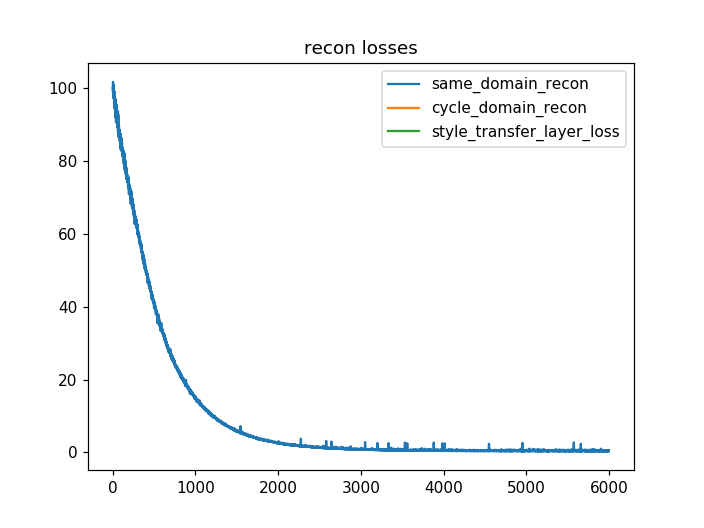

In [46]:
plt.plot(same_domain_recon_loss_history, label='same_domain_recon')
plt.plot(cycle_domain_recon_loss_history, label='cycle_domain_recon')
plt.plot(style_transfer_layer_loss_history, label='style_transfer_layer_loss')
plt.title('recon losses')
plt.legend()
plt.show()

In [37]:
plt.plot(sda_loss_history)

In [38]:
X_cat.shape

torch.Size([100, 605])

In [39]:
list(Target_Test_Mice_Names)+list(Target_Train_Mice_Names)+list(Source_Train_Mice_Names)

['MouseCKO2',
 'MouseCKU10',
 'MouseCKN2',
 'MouseCKV10',
 'MouseCKW2',
 'MouseCKU1',
 'MouseCKV4',
 'MouseCKY8',
 'MouseCKX1',
 'MouseCKY9',
 'MouseCKA1',
 'MouseCKO3',
 'MouseCKR1',
 'MouseCKL7',
 'MouseCKN1',
 'MouseCKY1',
 'MouseCKZ1',
 'MouseCKN3',
 'MouseCKY2',
 'MouseCKB9']

In [40]:
X_target_train_batches.shape

torch.Size([10, 605])

In [41]:
list(Target_Test_Mice_Names)

['MouseCKO2', 'MouseCKU10', 'MouseCKN2', 'MouseCKV10']

In [42]:
F.relu(model.W_nmf).shape

torch.Size([25, 605])

In [43]:
plt.plot(F.relu(model.W_nmf[3,:55].unsqueeze(dim=1)).detach().numpy())

In [44]:
F.relu(model.W_nmf[7,:55])

tensor([0.4230, 0.1682, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<ReluBackward0>)